    Feature  Importance
3   V_lag_3    0.638345
6   Q_lag_0    0.178671
13  M_lag_1    0.140205
0   V_lag_0    0.022165
15  M_lag_3    0.018361
10  Q_lag_4    0.000960
7   Q_lag_1    0.000757
11  Q_lag_5    0.000536
16  M_lag_4    0.000000
14  M_lag_2    0.000000
12  M_lag_0    0.000000
9   Q_lag_3    0.000000
1   V_lag_1    0.000000
8   Q_lag_2    0.000000
5   V_lag_5    0.000000
4   V_lag_4    0.000000
2   V_lag_2    0.000000
17  M_lag_5    0.000000


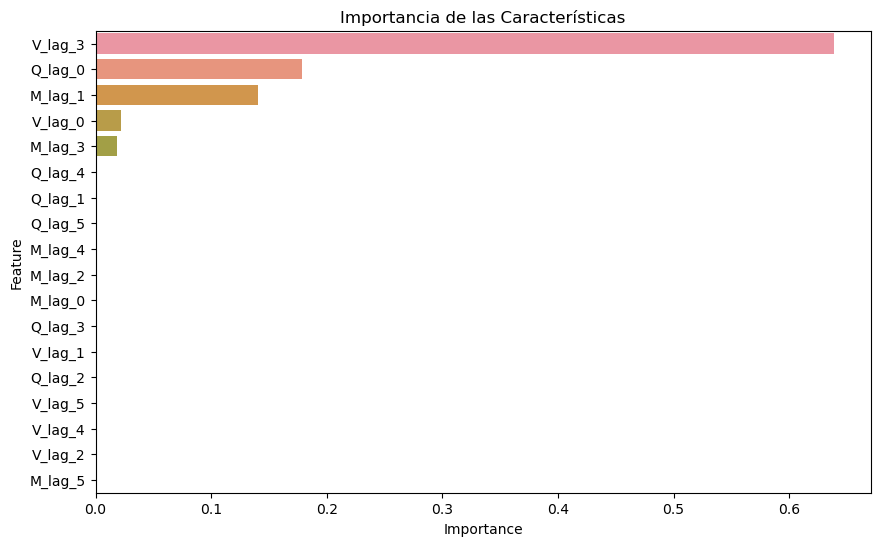

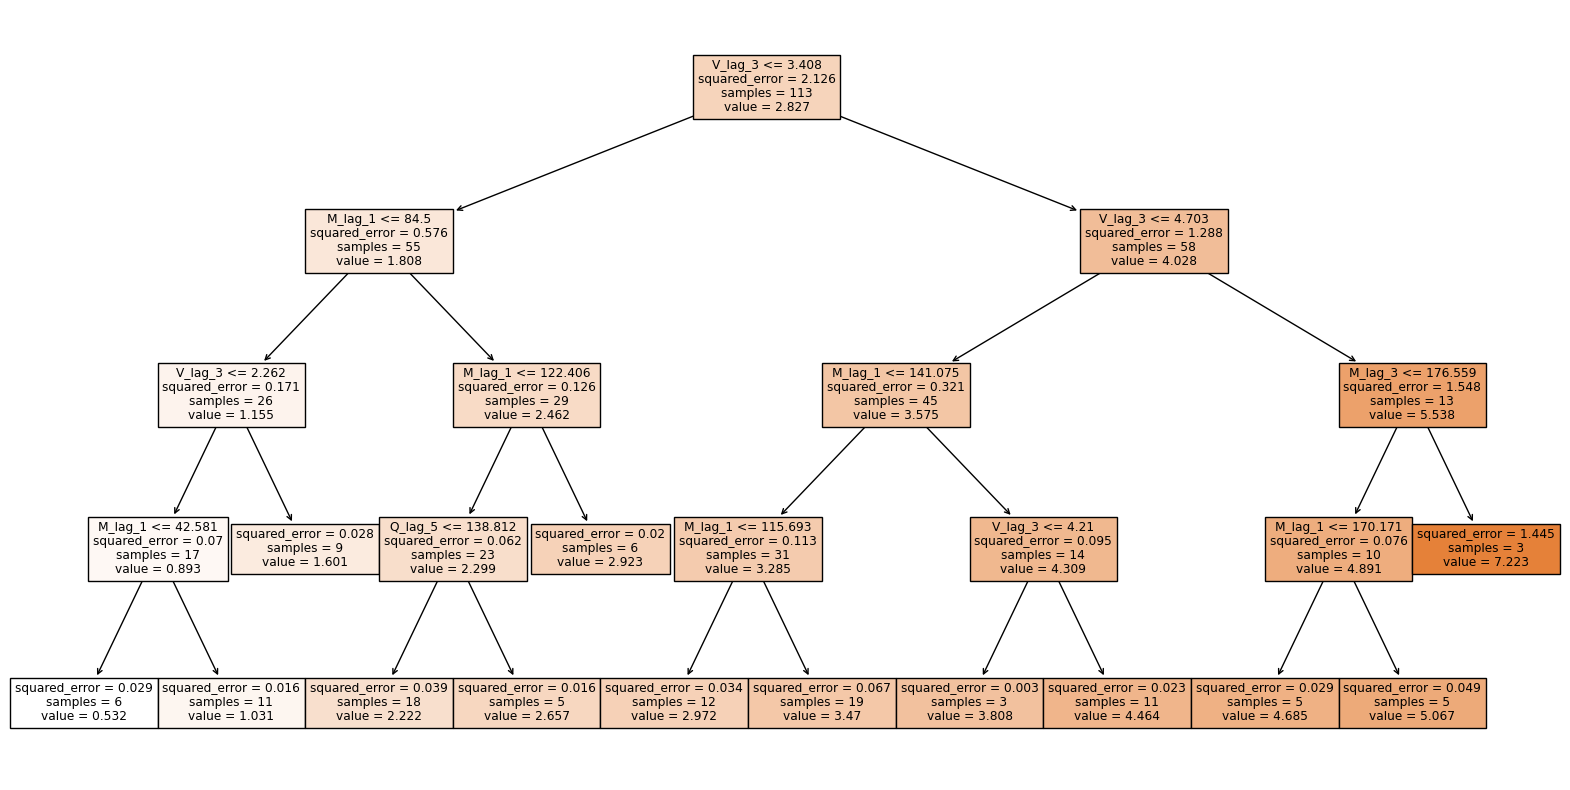

|--- V_lag_3 <= 3.41
|   |--- M_lag_1 <= 84.50
|   |   |--- V_lag_3 <= 2.26
|   |   |   |--- M_lag_1 <= 42.58
|   |   |   |   |--- value: [0.53]
|   |   |   |--- M_lag_1 >  42.58
|   |   |   |   |--- value: [1.03]
|   |   |--- V_lag_3 >  2.26
|   |   |   |--- value: [1.60]
|   |--- M_lag_1 >  84.50
|   |   |--- M_lag_1 <= 122.41
|   |   |   |--- Q_lag_5 <= 138.81
|   |   |   |   |--- value: [2.22]
|   |   |   |--- Q_lag_5 >  138.81
|   |   |   |   |--- value: [2.66]
|   |   |--- M_lag_1 >  122.41
|   |   |   |--- value: [2.92]
|--- V_lag_3 >  3.41
|   |--- V_lag_3 <= 4.70
|   |   |--- M_lag_1 <= 141.07
|   |   |   |--- M_lag_1 <= 115.69
|   |   |   |   |--- value: [2.97]
|   |   |   |--- M_lag_1 >  115.69
|   |   |   |   |--- value: [3.47]
|   |   |--- M_lag_1 >  141.07
|   |   |   |--- V_lag_3 <= 4.21
|   |   |   |   |--- value: [3.81]
|   |   |   |--- V_lag_3 >  4.21
|   |   |   |   |--- value: [4.46]
|   |--- V_lag_3 >  4.70
|   |   |--- M_lag_3 <= 176.56
|   |   |   |--- M_lag_1 <=

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree, export_text

# Función para generar M_1 con pendiente lineal suave, ruido gausiano y aumento del 5% cada 3 meses
def generar_M_1(meses):
    np.random.seed(42)
    ruido = np.random.normal(0, 25, len(meses))
    pendiente_suave = 0.7 * meses # Pendiente menor a la de M_1
    M_1 = 50 + pendiente_suave + ruido
    for i in range(0, len(meses), 6):
        pico = 2 + np.random.normal(0, 0.5) # Pico gausiano que duplica la velocidad
        M_1[i+1] += pico # Duración del pico: 1 meses
    return M_1


#Función para generar V_1 con pendiente lineal suave, picos gaussianos cada 6 meses y ruido
def generar_V_1(meses):
    np.random.seed(42)
    pendiente_suave = 0.02 * meses # Pendiente menor a la de M_1
    V_1 = 1.5 + pendiente_suave + np.random.normal(0, 0.1, len(meses))
    for i in range(0, len(meses), 6):
        pico = 1 + np.random.normal(0, 0.5) # Pico gausiano que triplica la velocidad
        V_1[i+2] += pico # Duración del pico: 2 meses
    return V_1


#Función para generar Q_1 con pendiente lineal suave, picos gaussianos cada 6 meses (2 meses después de los picos de V_1) y ruido
def generar_Q_1(meses):
    np.random.seed(42)
    pendiente_suave = 0.4 * meses # Pendiente levemente distinta a la de V_1
    Q_1 = 100 + pendiente_suave + np.random.normal(0, 10, len(meses))
    for i in range(2, len(meses), 6):
        pico = 10 + np.random.normal(0, 0.5) # Pico gausiano que duplica la producción base
        Q_1[i+2] += pico # Duración del pico: 2 meses
    return Q_1

# Generar datos
meses = np.arange(1, 181)
M_1 = generar_M_1(meses)
V_1 = generar_V_1(meses)
Q_1 = generar_Q_1(meses)

# Crear DataFrame
df = pd.DataFrame({
    'Meses': meses,
    'M_1': M_1,
    'V_1': V_1,
    'Q_1': Q_1
})

# Calcular P_1 sin desfase
df['P_1'] = (df['M_1'] * df['V_1']) / df['Q_1']


# Función para crear y desfasear el DataFrame
def crear_y_desfasear_dataframe(meses, V, M, Q, P):
    data = {
        'Meses': meses,
        'Velocidad del Dinero (V)': V,
        'Masa Monetaria (M)': M,
        'Producción Real (Q)': Q,
        'Nivel de Precios (P)': P,

    }
    df = pd.DataFrame(data)
    df['Velocidad del Dinero (V)'] = df['Velocidad del Dinero (V)'].shift(-3)
    df['Producción Real (Q)'] = df['Producción Real (Q)'].shift(0)
    df['Masa Monetaria (M)'] = df['Masa Monetaria (M)'].shift(-1)
    return df

# Crear el DataFrame con los datos desfasados
df = crear_y_desfasear_dataframe(meses, V_1, M_1, Q_1, df['P_1'])

# Eliminar filas con valores NaN resultantes del desfase
df = df.dropna().reset_index(drop=True)

# Crear características desfasadas (lags) hasta un máximo de 7 meses
for lag in range(0, 8):
    df[f'V_lag_{lag}'] = df['Velocidad del Dinero (V)'].shift(lag)
    df[f'M_lag_{lag}'] = df['Masa Monetaria (M)'].shift(lag)
    df[f'Q_lag_{lag}'] = df['Producción Real (Q)'].shift(lag)

# Eliminar filas con valores NaN nuevamente debido a la creación de lags
df = df.dropna().reset_index(drop=True)

# Definir características (lags) y variable objetivo
features = [f'V_lag_{i}' for i in range(0, 6)] + [f'Q_lag_{i}' for i in range(0, 6)] + [f'M_lag_{i}' for i in range(0, 6)]
target = 'Nivel de Precios (P)'

# Entrenar un modelo de Random Forest con hiperparámetros ajustados
X = df[features]
y = df[target]

model = RandomForestRegressor(
    n_estimators=5,
    max_depth=4,
    min_samples_split=10,
    min_samples_leaf=3,
    random_state=42
)
model.fit(X, y)

# Obtener la importancia de las características
feature_importances = model.feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Imprimir la importancia de las características
print(feature_importances_df)

# Visualizar la importancia de las características
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances_df, x='Importance', y='Feature')
plt.title('Importancia de las Características')
plt.show()

# Imprimir un árbol de decisión del bosque aleatorio
# Seleccionamos el primer árbol
tree = model.estimators_[0]
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=features, filled=True)
plt.show()

# Exportar texto del árbol de decisión para ver las reglas
tree_text = export_text(tree, feature_names=features)
print(tree_text)

# Seleccionar las tres características más importantes
top_features = feature_importances_df['Feature'].head(3).tolist()

# Crear un nuevo DataFrame con la variable target (P) y las tres características más importantes
df_top_features = df[['Nivel de Precios (P)'] + top_features]



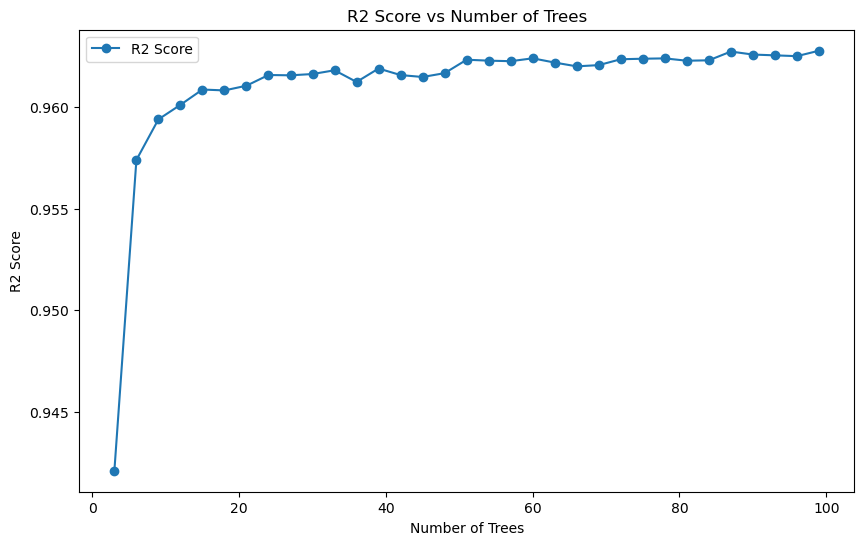

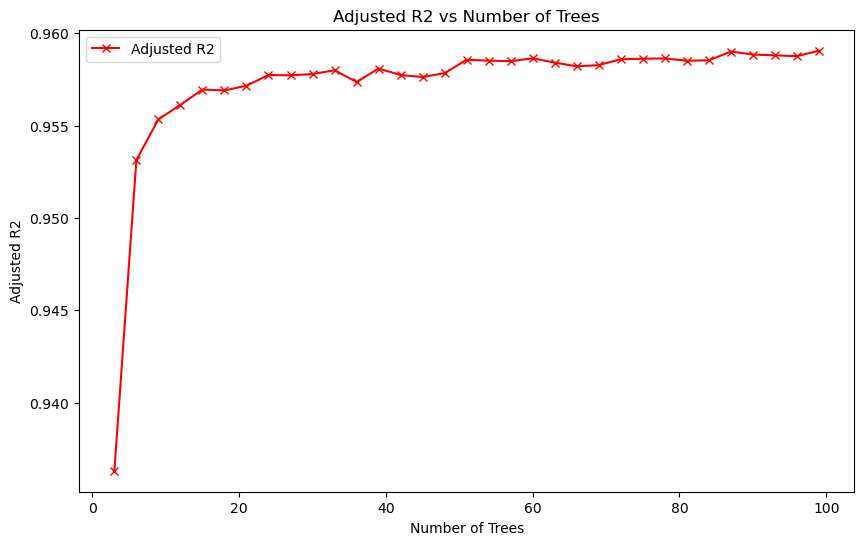

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Espacio de parámetros
params = {
    'sample_size_ratio': 1/3,  # Cantidad de datos de muestreo (1/3 del total)
    'validation_size_ratio': 0.2,  # Cantidad de datos de validación (20% del total de datos)
    'n_estimators': 100,  # Número de árboles en el random forest
    'tree_type': 'regressor',  # Tipo de árbol: 'regressor' o 'classifier'
    'random_state': 42,  # Semilla para la reproducibilidad
    'max_depth': None,  # Profundidad máxima de los árboles
    'min_samples_leaf': 1,  # Número mínimo de muestras por hoja
    'n_splits': 5  # Número de splits para bootstrapping
}

# Definir el dataframe
df = df_top_features

# Separar características y objetivo
X = df.drop(columns=['Nivel de Precios (P)'])
y = df['Nivel de Precios (P)']

# Dividir el conjunto de datos en entrenamiento y validación
X_train_full, X_val, y_train_full, y_val = train_test_split(X, y, test_size=params['validation_size_ratio'], random_state=params['random_state'])

# Función para calcular R2 ajustado
def calculate_adjusted_r2(n, r2, k):
    if n - k - 1 == 0:
        return np.nan  # Para evitar la división por cero
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
    return adjusted_r2

# Función para realizar el muestreo con bootstrapping y entrenamiento del modelo
def train_random_forest(params, X_train_full, y_train_full, X_val, y_val):
    r2_scores = []
    adjusted_r2_scores = []
    total_indices = set(X_train_full.index)
    selected_indices = set()

    for i in range(params['n_splits']):
        # Muestreo aleatorio con bootstrapping
        sample_size = int(len(X_train_full) * params['sample_size_ratio'])
        X_train, _, y_train, _ = train_test_split(X_train_full, y_train_full, train_size=sample_size, random_state=params['random_state'] + i, shuffle=True)
        
        # Registrar los índices seleccionados
        selected_indices.update(X_train.index)
        
        # Seleccionar el tipo de modelo
        if params['tree_type'] == 'regressor':
            model = RandomForestRegressor(
                n_estimators=params['n_estimators'],
                random_state=params['random_state'],
                max_depth=params['max_depth'],
                min_samples_leaf=params['min_samples_leaf']
            )
        else:
            model = RandomForestClassifier(       #Lo agregue pensando en realizar pruebas futuras
                n_estimators=params['n_estimators'],
                random_state=params['random_state'],
                max_depth=params['max_depth'],
                min_samples_leaf=params['min_samples_leaf']
            )
        
        # Entrenar el modelo
        model.fit(X_train, y_train)
        
        # Predicción
        y_pred = model.predict(X_val)
        
        # Calcular R2 y almacenar
        r2 = r2_score(y_val, y_pred)
        r2_scores.append(r2)
        
        # Calcular R2 ajustado y almacenar
        n = len(y_val)
        k = X_train.shape[1]  # número de características
        adjusted_r2 = calculate_adjusted_r2(n, r2, k)
        adjusted_r2_scores.append(adjusted_r2)

    return r2_scores, adjusted_r2_scores, selected_indices

# Función para graficar error vs número de árboles
def plot_error_vs_trees(params, X_train_full, y_train_full, X_val, y_val):
    n_trees = list(range(3, params['n_estimators'] + 1, 3))
    r2_scores = []
    adjusted_r2_scores = []

    for n in n_trees:
        params['n_estimators'] = n
        r2, adjusted_r2, _ = train_random_forest(params, X_train_full, y_train_full, X_val, y_val)
        r2_scores.append(np.mean(r2))
        adjusted_r2_scores.append(np.mean(adjusted_r2))

    # Gráfico de R2 Score vs Número de Árboles
    plt.figure(figsize=(10, 6))
    plt.plot(n_trees, r2_scores, marker='o', label='R2 Score')
    plt.xlabel('Number of Trees')
    plt.ylabel('R2 Score')
    plt.title('R2 Score vs Number of Trees')
    plt.legend()
    plt.show()

    # Gráfico de R2 Ajustado vs Número de Árboles
    plt.figure(figsize=(10, 6))
    plt.plot(n_trees, adjusted_r2_scores, marker='x', label='Adjusted R2', color='red')
    plt.xlabel('Number of Trees')
    plt.ylabel('Adjusted R2')
    plt.title('Adjusted R2 vs Number of Trees')
    plt.legend()
    plt.show()

# Ejecutar y visualizar los gráficos
plot_error_vs_trees(params, X_train_full, y_train_full, X_val, y_val)

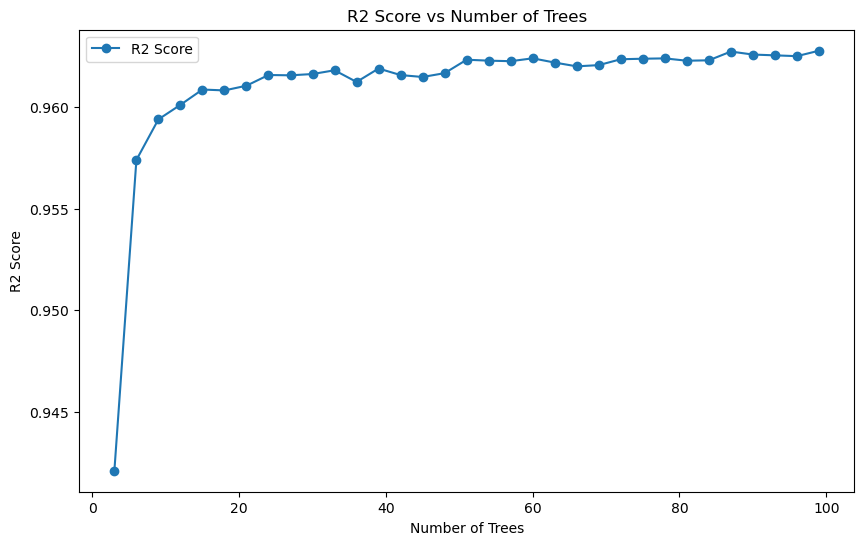

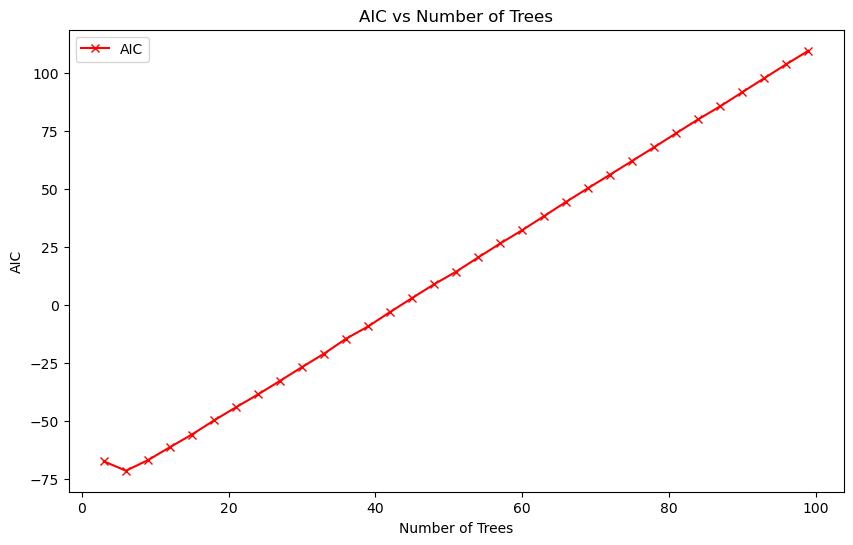

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Espacio de parámetros
params = {
    'sample_size_ratio': 1/3,  # Cantidad de datos de muestreo (1/3 del total)
    'validation_size_ratio': 0.2,  # Cantidad de datos de validación (20% del total de datos)
    'n_estimators': 100,  # Número de árboles en el random forest
    'tree_type': 'regressor',  # Tipo de árbol: 'regressor' o 'classifier'
    'random_state': 42,  # Semilla para la reproducibilidad
    'max_depth': None,  # Profundidad máxima de los árboles
    'min_samples_leaf': 1,  # Número mínimo de muestras por hoja
    'n_splits': 5  # Número de splits para bootstrapping
}

# Definir el dataframe
df = df_top_features

# Separar características y objetivo
X = df.drop(columns=['Nivel de Precios (P)'])
y = df['Nivel de Precios (P)']

# Dividir el conjunto de datos en entrenamiento y validación
X_train_full, X_val, y_train_full, y_val = train_test_split(X, y, test_size=params['validation_size_ratio'], random_state=params['random_state'])

# Función para calcular AIC modificado
def calculate_aic(n, mse, k):
    aic = 2 * k + n * np.log(mse)
    return aic

# Función para realizar el muestreo con bootstrapping y entrenamiento del modelo
def train_random_forest(params, X_train_full, y_train_full, X_val, y_val):
    r2_scores = []
    aic_scores = []
    total_indices = set(X_train_full.index)
    selected_indices = set()

    for i in range(params['n_splits']):
        # Muestreo aleatorio con bootstrapping
        sample_size = int(len(X_train_full) * params['sample_size_ratio'])
        X_train, _, y_train, _ = train_test_split(X_train_full, y_train_full, train_size=sample_size, random_state=params['random_state'] + i, shuffle=True)
        
        # Registrar los índices seleccionados
        selected_indices.update(X_train.index)
        
        # Seleccionar el tipo de modelo
        if params['tree_type'] == 'regressor':
            model = RandomForestRegressor(
                n_estimators=params['n_estimators'],
                random_state=params['random_state'],
                max_depth=params['max_depth'],
                min_samples_leaf=params['min_samples_leaf']
            )
        else:
            model = RandomForestClassifier(
                n_estimators=params['n_estimators'],
                random_state=params['random_state'],
                max_depth=params['max_depth'],
                min_samples_leaf=params['min_samples_leaf']
            )
        
        # Entrenar el modelo
        model.fit(X_train, y_train)
        
        # Predicción
        y_pred = model.predict(X_val)
        
        # Calcular R2 y almacenar
        r2 = r2_score(y_val, y_pred)
        r2_scores.append(r2)
        
        # Calcular AIC modificado y almacenar
        mse = mean_squared_error(y_val, y_pred)
        n = len(y_val)
        k = params['n_estimators']  # número de árboles como proxy para el número de parámetros
        aic = calculate_aic(n, mse, k)
        aic_scores.append(aic)

    return r2_scores, aic_scores, selected_indices

# Función para graficar error vs número de árboles
def plot_error_vs_trees(params, X_train_full, y_train_full, X_val, y_val):
    n_trees = list(range(3, params['n_estimators'] + 1, 3))
    r2_scores = []
    aic_scores = []

    for n in n_trees:
        params['n_estimators'] = n
        r2, aic, _ = train_random_forest(params, X_train_full, y_train_full, X_val, y_val)
        r2_scores.append(np.mean(r2))
        aic_scores.append(np.mean(aic))

    # Gráfico de R2 Score vs Número de Árboles
    plt.figure(figsize=(10, 6))
    plt.plot(n_trees, r2_scores, marker='o', label='R2 Score')
    plt.xlabel('Number of Trees')
    plt.ylabel('R2 Score')
    plt.title('R2 Score vs Number of Trees')
    plt.legend()
    plt.show()

    # Gráfico de AIC vs Número de Árboles
    plt.figure(figsize=(10, 6))
    plt.plot(n_trees, aic_scores, marker='x', label='AIC', color='red')
    plt.xlabel('Number of Trees')
    plt.ylabel('AIC')
    plt.title('AIC vs Number of Trees')
    plt.legend()
    plt.show()

# Ejecutar y visualizar los gráficos
plot_error_vs_trees(params, X_train_full, y_train_full, X_val, y_val)

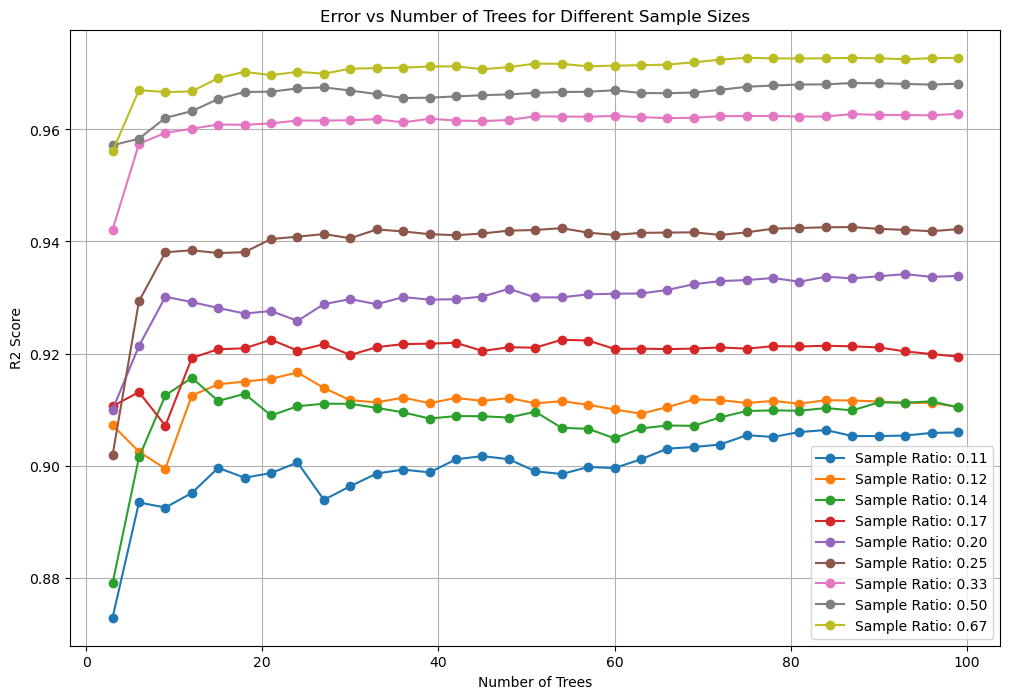

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Espacio de parámetros
params = {
    'validation_size_ratio': 0.2,  # Cantidad de datos de validación (20% del total de datos)
    'tree_type': 'regressor',  # Tipo de árbol: 'regressor' o 'classifier'
    'random_state': 42,  # Semilla para la reproducibilidad
    'max_depth': None,  # Profundidad máxima de los árboles
    'min_samples_leaf': 1,  # Número mínimo de muestras por hoja
    'n_splits': 5  # Número de splits para bootstrapping
}

# Definir el dataframe
df = df_top_features

# Separar características y objetivo
X = df.drop(columns=['Nivel de Precios (P)'])
y = df['Nivel de Precios (P)']

# Dividir el conjunto de datos en entrenamiento y validación
X_train_full, X_val, y_train_full, y_val = train_test_split(X, y, test_size=params['validation_size_ratio'], random_state=params['random_state'])

# Función para calcular AIC
def calculate_aic(n, mse, k):
    aic = n * np.log(mse) + 2 * k
    return aic

# Función para realizar el muestreo con bootstrapping y entrenamiento del modelo
def train_random_forest(params, X_train_full, y_train_full, X_val, y_val, n_estimators):
    r2_scores = []
    aic_scores = []

    for i in range(params['n_splits']):
        # Muestreo aleatorio con bootstrapping
        sample_size = int(len(X_train_full) * params['sample_size_ratio'])
        X_train, _, y_train, _ = train_test_split(X_train_full, y_train_full, train_size=sample_size, random_state=params['random_state'] + i, shuffle=True)
        
        # Seleccionar el tipo de modelo
        if params['tree_type'] == 'regressor':
            model = RandomForestRegressor(
                n_estimators=n_estimators,
                random_state=params['random_state'],
                max_depth=params['max_depth'],
                min_samples_leaf=params['min_samples_leaf']
            )
        else:
            model = RandomForestClassifier(
                n_estimators=n_estimators,
                random_state=params['random_state'],
                max_depth=params['max_depth'],
                min_samples_leaf=params['min_samples_leaf']
            )
        
        # Entrenar el modelo
        model.fit(X_train, y_train)
        
        # Predicción
        y_pred = model.predict(X_val)
        
        # Calcular R2 y almacenar
        r2 = r2_score(y_val, y_pred)
        r2_scores.append(r2)
        
        # Calcular AIC y almacenar
        mse = mean_squared_error(y_val, y_pred)
        n = len(y_val)
        k = n_estimators  # número de parámetros ajustados (número de árboles)
        aic = calculate_aic(n, mse, k)
        aic_scores.append(aic)

    return r2_scores, aic_scores

# Función para graficar error vs número de árboles para diferentes tamaños de muestra
def plot_error_vs_trees_for_sample_sizes(params, X_train_full, y_train_full, X_val, y_val):
    sample_ratios = [1/9, 1/8, 1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 2/3]
    n_trees = list(range(3, 100 + 1, 3))  # Ajusta el rango y paso según tus necesidades
    
    plt.figure(figsize=(12, 8))

    for ratio in sample_ratios:
        params['sample_size_ratio'] = ratio
        r2_scores = []

        for n in n_trees:
            r2, _ = train_random_forest(params, X_train_full, y_train_full, X_val, y_val, n_estimators=n)
            r2_scores.append(np.mean(r2))

        plt.plot(n_trees, r2_scores, marker='o', label=f'Sample Ratio: {ratio:.2f}')

    plt.xlabel('Number of Trees')
    plt.ylabel('R2 Score')
    plt.title('Error vs Number of Trees for Different Sample Sizes')
    plt.legend()
    plt.grid(True)
    plt.show()

# Ejecutar y visualizar el gráfico
plot_error_vs_trees_for_sample_sizes(params, X_train_full, y_train_full, X_val, y_val)

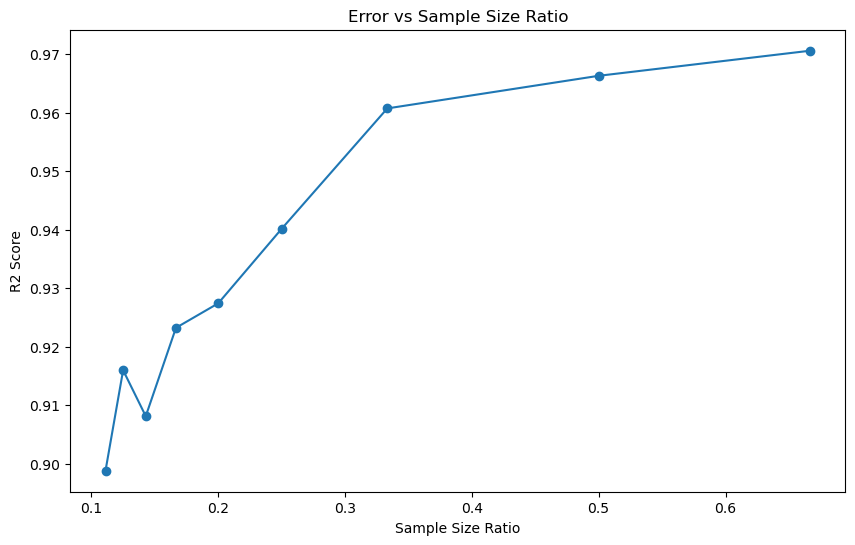

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Espacio de parámetros
params = {
    'sample_size_ratio': 1/3,  # Cantidad de datos de muestreo (1/3 del total)
    'validation_size_ratio': 0.2,  # Cantidad de datos de validación (20% del total de datos)
    'n_estimators': 20,  # Número de árboles en el random forest
    'tree_type': 'regressor',  # Tipo de árbol: 'regressor' o 'classifier'
    'random_state': 42,  # Semilla para la reproducibilidad
    'max_depth': None,  # Profundidad máxima de los árboles
    'min_samples_leaf': 1,  # Número mínimo de muestras por hoja
    'n_splits': 5  # Número de splits para bootstrapping
}

# Definir el dataframe
df = df_top_features

# Separar características y objetivo
X = df.drop(columns=['Nivel de Precios (P)'])
y = df['Nivel de Precios (P)']

# Dividir el conjunto de datos en entrenamiento y validación
X_train_full, X_val, y_train_full, y_val = train_test_split(X, y, test_size=params['validation_size_ratio'], random_state=params['random_state'])

# Función para calcular AIC
def calculate_aic(n, mse, k):
    aic = n * np.log(mse) + 2 * k
    return aic

# Función para realizar el muestreo con bootstrapping y entrenamiento del modelo
def train_random_forest(params, X_train_full, y_train_full, X_val, y_val):
    r2_scores = []
    aic_scores = []
    total_indices = set(X_train_full.index)
    selected_indices = set()

    for i in range(params['n_splits']):
        # Muestreo aleatorio con bootstrapping
        sample_size = int(len(X_train_full) * params['sample_size_ratio'])
        X_train, _, y_train, _ = train_test_split(X_train_full, y_train_full, train_size=sample_size, random_state=params['random_state'] + i, shuffle=True)
        
        # Registrar los índices seleccionados
        selected_indices.update(X_train.index)
        
        # Seleccionar el tipo de modelo
        if params['tree_type'] == 'regressor':
            model = RandomForestRegressor(
                n_estimators=params['n_estimators'],
                random_state=params['random_state'],
                max_depth=params['max_depth'],
                min_samples_leaf=params['min_samples_leaf']
            )
        else:
            model = RandomForestClassifier(
                n_estimators=params['n_estimators'],
                random_state=params['random_state'],
                max_depth=params['max_depth'],
                min_samples_leaf=params['min_samples_leaf']
            )
        
        # Entrenar el modelo
        model.fit(X_train, y_train)
        
        # Predicción
        y_pred = model.predict(X_val)
        
        # Calcular R2 y almacenar
        r2 = r2_score(y_val, y_pred)
        r2_scores.append(r2)
        
        # Calcular AIC y almacenar
        mse = mean_squared_error(y_val, y_pred)
        n = len(y_val)
        k = params['n_estimators']  # número de parámetros ajustados (número de árboles)
        aic = calculate_aic(n, mse, k)
        aic_scores.append(aic)

    return r2_scores, aic_scores, selected_indices

# Función para graficar error vs tamaño de muestra de bootstrapping
def plot_error_vs_sample_size(params, X_train_full, y_train_full, X_val, y_val):
    sample_ratios = [1/9, 1/8, 1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 2/3]
    r2_scores = []

    for ratio in sample_ratios:
        params['sample_size_ratio'] = ratio
        r2, _, _ = train_random_forest(params, X_train_full, y_train_full, X_val, y_val)
        r2_scores.append(np.mean(r2))

    plt.figure(figsize=(10, 6))
    plt.plot(sample_ratios, r2_scores, marker='o')
    plt.xlabel('Sample Size Ratio')
    plt.ylabel('R2 Score')
    plt.title('Error vs Sample Size Ratio')
    plt.show()

# Ejecutar y visualizar el gráfico de error en función del tamaño de la muestra
plot_error_vs_sample_size(params, X_train_full, y_train_full, X_val, y_val)